# Clustering Analysis

## DGUFS

**To Do**
* Compare detected clusters to non-redundant/redundant feature sets derived from model comparison experiments.
* Apply group LASSO to clusters from DGUFS. DGUFS performs siml. clustering and feature selection. Optimize DGUFS cluster quality according to metric from paper.


In [1]:
import numpy as np
import pandas as pd
import altair as alt

import concensus_clustering

from copy import deepcopy


from sklearn.cluster.bicluster import SpectralCoclustering
from sklearn.cluster.bicluster import SpectralBiclustering
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import ParameterGrid

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
feature_categories = [
    'shape',
    'firstorder',
    'glcm',
    'glrlm',
    'glszm',
    'gldm',
    'ngtdm',
    'PETparam', 
    'clinical'
]

In [3]:
def category_counts(_):
    
    return {
        'shape': 0,
        'firstorder': 0,
        'glcm': 0,
        'glrlm': 0,
        'glszm': 0,
        'gldm': 0,
        'ngtdm': 0,
        'PETparam': 0,
        'clinical': 0,
    }


def _update_count(pet_output, ct_output, key):

    if 'PET' in key:
        pet_output[key] += 1
    else:
        ct_output[key] += 1
            
    return pet_output, ct_output


def _norm_count(pet_output, ct_output, key, tot_counts):
    
    if 'PET' in key:
        pet_output[key] /= tot_counts[key]
    else:
        ct_output[key] /= tot_counts[key]
            
    return pet_output, ct_output


def to_feature_categories(cluster_indices):
    
    pet_output = category_counts(None)
    ct_output = category_counts(None)
    
    
    for label in X.columns[cluster_indices]:
        if 'shape' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'shape')
        elif 'firstorder' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'firstorder')
        elif 'glcm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glcm')
        elif 'glrlm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glrlm')
        elif 'glszm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'glszm')
        elif 'gldm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'gldm')
        elif 'ngtdm' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'ngtdm')
        elif 'PETparam' in label:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'PETparam')
        else:
            pet_output, ct_output = _update_count(pet_output, ct_output, 'clinical')
        
    feature_counts = {
        'shape': 13,
        'firstorder': 54,
        'glcm': 69,
        'glrlm': 48,
        'glszm': 48,
        'gldm': 42,
        'ngtdm': 15,
        'PETparam': 3, 
        'clinical': 42
    }
    for label in feature_counts.keys():
        pet_output, ct_output = _norm_count(pet_output, ct_output, label, feature_counts)

    return pet_output, ct_output

In [4]:
# NB: For average Pearson use -1.0 * abs(rho). As rho improves 
# (indicating better results) a larger amount is subtracted to the 
# output indicating better overall biclusters.
def meta_score(scores, weights=None):
    """The weighted arithmetic mean of multiple scores.""" 
    
    if weights is None:
        weights = [0.5] * len(scores)
    
    outcome = 0
    for score, weight in zip(scores, weights):
        outcome = outcome + weight * -1.0 * abs(score)
        
    return outcome / len(scores)

In [5]:
def biclusters(model, X, param_config):
    # Create Bicluster instances tracking detected clusters.
    
    # Start fresh with each clustering.
    _model = deepcopy(model)
    
    # Set number of clusters to detect and fit model to data.
    _model.set_params(**param_config)
    _model.fit(X)

    rows, cols = _model.rows_, _model.columns_
    # Sanity check.
    assert np.shape(rows)[0] == np.shape(cols)[0]
    
    biclusters = concensus_clustering.Biclusters(
        rows=rows, cols=cols, data=X
    )
    return biclusters

In [6]:
def checker_coords(model, num_clusters):
    # Collect coordinates for biclusters with a checkerborad structure.
    
    tot_num_clusters = num_clusters[0] * num_clusters[1]
    coords = pd.DataFrame(
        np.zeros((tot_num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    
    num, prev_rows = 0, 0
    for row_num in range(num_clusters[0]):
        nrows = np.sum(model.rows_[row_num])

        prev_cols = 0
        for col_num in range(num_clusters[1]):
            ncols = np.sum(model.columns_[col_num])

            coords.iloc[num, 0] = prev_rows + 1
            coords.iloc[num, 1] = prev_rows + nrows
            coords.iloc[num, 2] = prev_cols
            coords.iloc[num, 3] = prev_cols + ncols

            num += 1

            prev_cols += ncols
        prev_rows += nrows - 1

    return coords

In [7]:
def bic_coords(model, num_clusters):
    # Collect coordinates for block diagonal biclusters.

    coords = pd.DataFrame(
        np.zeros((num_clusters, 4)),
        columns=('y1', 'y2', 'x1', 'x2')
    )
    prev_rows, prev_cols = 0, 0
    for num, row_bic in enumerate(model.rows_):
        num_rows = np.sum(row_bic)
        num_cols = np.sum(model.columns_[num])

        coords.iloc[num, 0] = prev_rows
        coords.iloc[num, 1] = prev_rows + num_rows
        coords.iloc[num, 2] = prev_cols
        coords.iloc[num, 3] = prev_cols + num_cols

        prev_rows += num_rows
        prev_cols += num_cols

    return coords

In [8]:
SEED = 0

In [9]:
y = pd.read_csv('./../../../data_source/to_analysis/target_dfs.csv', index_col=0)
y = np.squeeze(y.values)

In [10]:
X = pd.read_csv('./../../../data_source/to_analysis/no_filter_concat.csv', index_col=0)
X.head()

,original_shape_Elongation,original_shape_Flatness,original_shape_LeastAxis,original_shape_MajorAxis,original_shape_Maximum2DDiameterColumn,original_shape_Maximum2DDiameterRow,original_shape_Maximum2DDiameterSlice,original_shape_Maximum3DDiameter,original_shape_MinorAxis,original_shape_Sphericity,...,PET_original_gldm_SmallDependenceHighGrayLevelEmphasis.2,PET_original_gldm_SmallDependenceLowGrayLevelEmphasis.2,PET_original_ngtdm_Busyness.2,PET_original_ngtdm_Coarseness.2,PET_original_ngtdm_Complexity.2,PET_original_ngtdm_Contrast.2,PET_original_ngtdm_Strength.2,PETparam_SUVpeak,PETparam_MTV,PETparam_TLG
patient,,,,,,,,,,,,,,,,,,,,,
2,0.738882,0.723925,27.060529,37.380273,41.976184,44.598206,42.720019,45.617979,27.619612,0.661532,...,4430.229066,0.000370,0.025559,0.004672,27568.285932,0.296325,70.049351,21.616549,7.384,124.870726
4,0.796900,0.629917,19.845151,31.504408,38.587563,35.468296,29.410882,38.704005,25.105855,0.701721,...,4270.509796,0.000527,0.027591,0.007443,31578.673152,0.271854,156.965282,15.296275,3.406,41.554406
5,0.600926,0.535140,22.515072,42.073251,46.065171,43.011626,32.015621,46.454279,25.282894,0.762365,...,4096.292481,0.000460,0.022439,0.005178,24870.405544,0.230801,64.918103,14.473272,7.934,86.228420
8,0.784571,0.414247,30.263897,73.057649,74.148500,80.956779,65.764732,83.438600,57.318945,0.520001,...,1198.601513,0.000319,0.139365,0.001371,11651.530760,0.081103,15.731158,10.510859,26.926,205.413389
10,0.690320,0.539743,19.449801,36.035312,33.286634,38.013156,33.015148,43.150898,24.875896,0.643822,...,1122.798029,0.000459,0.048381,0.005789,7160.791790,0.118371,29.024761,7.213190,6.041,32.103770


In [11]:
X_std = StandardScaler().fit_transform(X.values)
X_std.shape

(198, 610)

# Spectral Biclustering

Ref: Kluger, Yuval, et. al., 2003. Spectral biclustering of microarray data: coclustering genes and conditions.
* [blog](http://www.kemaleren.com/post/spectral-biclustering-part-1/)

In [12]:
np.random.seed(0)
bic_grid = ParameterGrid(
    {
        'n_clusters': [
            np.random.choice(np.arange(30), size=2) for _ in range(25)
        ],
        'n_components': [6, 9, 10],
        'n_best': [1, 3, 6],
        
    }
)
# Id config with best score results and plot with grid.
bic_scores = {}
for num, bic_param_config in enumerate(bic_grid):
    try:
        bic_model = SpectralBiclustering(
            random_state=SEED, method='log', svd_method='arpack'
        )
        bic_clusters = biclusters(
            bic_model, X_std, bic_param_config
        )
        bic_scores[num] = bic_clusters.external_metrics
    except:
        pass

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:92: RuntimeWarning: divide by zero encountered in log
  n_local_trials = 2 + int(np.log(n_clusters))
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/cluster/k_means_.py:92: RuntimeWarning: divide by zero encountered in log
  n_local_trials = 2 + int(np.log(n_clu

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = 

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = 

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:50: RuntimeWarning: divide by zero encountered in true_divide
  smsr_values = msr_values / (avg_rows ** 2 * avg_cols ** 2)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_

In [13]:
# Determine best biclustering config.
avg_bic_scores = []
for scores in bic_scores.values():
    _, non_inf_idx = np.where(scores.values != float('inf'))
    score = sum(scores.values.ravel()[non_inf_idx]) / len(non_inf_idx)
    avg_bic_scores.append(score)
    
best_config = bic_grid[np.argmin(avg_bic_scores)]
best_config, min(avg_bic_scores)

({'n_components': 10, 'n_clusters': array([13,  8]), 'n_best': 6},
 0.6052992748819872)

In [14]:
bic_model = SpectralBiclustering(
    random_state=SEED, method='log', svd_method='arpack'
)
bic_model.set_params(**best_config)
bic_model.fit(X_std)
bic_row_sorted = X_std[np.argsort(bic_model.row_labels_), :]
bic_fit_data = bic_row_sorted[:, np.argsort(bic_model.column_labels_)]

### Row clusters

In [15]:
# The proportion of patient outcomes per row bicluster.

bic_row_ids = []
bic_pfs_outcome, bic_not_pfs_outcome = [], []

for bic_row_idx in np.unique(bic_model.row_labels_):
    # Store cluster index.
    bic_row_ids.append(bic_row_idx)
    
    # ID samples belonging to current cluster.
    row_cluster_samples = np.where(bic_model.row_labels_ == bic_row_idx)
    
    # Store fractions of each outcome for current cluster.
    bic_pfs_outcome.append(sum(y[row_cluster_samples] == 0) / np.size(y))
    bic_not_pfs_outcome.append(sum(y[row_cluster_samples] == 1) / np.size(y))
    
sum(bic_pfs_outcome), sum(bic_not_pfs_outcome), len(bic_row_ids)

(0.6767676767676769, 0.3232323232323232, 13)

In [16]:
sorted_cluster_idx = np.concatenate((bic_row_ids, bic_row_ids))
comb_results = np.concatenate((bic_pfs_outcome, bic_not_pfs_outcome))

results_id =  np.concatenate((
    ['Progression-free Survival'] * len(bic_pfs_outcome), 
    ['Other Event'] * len(bic_not_pfs_outcome)
))
df_bic_stats = pd.DataFrame(
    {
        'comb_results': comb_results,
        'results_id': results_id
    },
    index=sorted_cluster_idx,
)
df_bic_stats.head()

,comb_results,results_id
0,0.050505,Progression-free Survival
1,0.025253,Progression-free Survival
2,0.075758,Progression-free Survival
3,0.035354,Progression-free Survival
4,0.075758,Progression-free Survival


In [17]:
sum(df_bic_stats['comb_results'])

1.0000000000000002

In [18]:
(a, b) = df_bic_stats.groupby('results_id')
a[0], a[1]['comb_results'].sum(), b[0], b[1]['comb_results'].sum()

('Other Event',
 0.3232323232323232,
 'Progression-free Survival',
 0.6767676767676767)

### Column clusters

In [19]:
# The number of features from each feature category per column bicluster.

pet_category_stats = {}
ct_category_stats = {}

for bic_col_idx in np.unique(bic_model.column_labels_):    
    # ID samples belonging to current cluster.
    col_cluster_samples = np.squeeze(np.where(bic_model.column_labels_ == bic_col_idx))
    # Store fractions of present feature categories per modality.
    pet_output, ct_output = to_feature_categories(col_cluster_samples)
    pet_category_stats[bic_col_idx] = pet_output
    ct_category_stats[bic_col_idx] = ct_output
    
pet_df = pd.DataFrame(pet_category_stats).T
ct_df = pd.DataFrame(ct_category_stats).T

In [20]:
frames = {}
# NB: Not all features can be divided into PET/CT categories.
for pet_col, ct_col in zip(pet_df, ct_df):
    
    
    assert pet_col == ct_col
    if 'clinical' in pet_col:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col]],

        )
        frame = frame.T
        frame.columns=['clinical']
        
    elif 'shape' in pet_col:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col]],

        )
        frame = frame.T
        frame.columns=['shape']
    else:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col], pet_df.loc[:, pet_col]],

        )
        frame = frame.T
        frame.columns = ['CT', 'PET']
    
    frame.index = np.arange(frame.index.size) + 1
    frames[ct_col] = frame

frames.keys()

dict_keys(['PETparam', 'clinical', 'firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm', 'shape'])

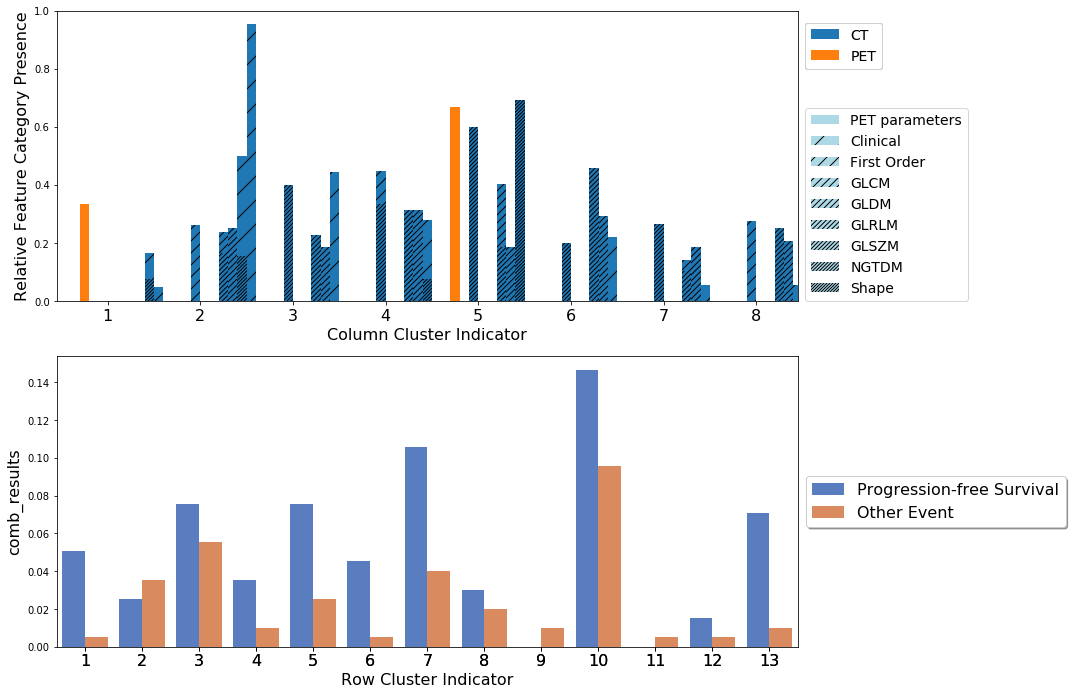

In [21]:
# * Possible to separate patients based on clinical outcomes whilst
#   identifying separating features?
# * Hue row (patient) clusters according to outcome. Capable of producing clusters with
#   pure outcomes? If so, which features separates a pure PFS outcome cluster from a 
#   cluster with no PFS outcomes?


H = '/'
labels = [
    'PET parameters', 'Clinical', 'First Order', 
    'GLCM', 'GLDM', 'GLRLM', 'GLSZM', 'NGTDM', 
    'Shape'
]

n_df = len(frames.keys())
n_col = len(list(frames.values())[0].columns) 
n_ind = len(list(frames.values())[0].index)

fig, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axis1.set_ylabel('Relative Feature Category Presence', fontsize=16)
axis1.set_xlabel('Column Cluster Indicator', fontsize=16)
for df in frames.values():
    df.plot(
        kind='bar',
        linewidth=0,
        stacked=True,
        ax=axis1,
        legend=False,
        grid=False
    )
    h, l = axis1.get_legend_handles_labels() 
    for i in range(0, n_df * n_col, n_col): 
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: 
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) 
                rect.set_width(1 / float(n_df + 1))

    axis1.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axis1.set_xticklabels(df.index, rotation=0, fontsize=16)
    
    n = []        
    for i in range(n_df):
        n.append(axis1.bar(0, 0, color='lightblue', hatch=H * i))
    
    l1 = axis1.legend(h[:n_col], l[:n_col], loc=[1.01, 0.8], fontsize=14)
    l2 = axis1.legend(n, labels, loc=[1.01, 0], fontsize=14) 
    axis1.add_artist(l1)
    

axis2.set_xlabel('Row Cluster Indicator', fontsize=16)
axis2.set_ylabel('Relative Outcome Category Presence', fontsize=16)
sns.barplot(
    x=sorted_cluster_idx,
    y='comb_results',
    hue='results_id',
    data=df_bic_stats,
    palette='muted',
    ax=axis2
)

axis2.legend(
    fontsize=16,
    loc='center left', 
    bbox_to_anchor=(1, 0.5),
    ncol=1, 
    fancybox=True, 
    shadow=True
)

axis2.set_xticks(sorted_cluster_idx)
axis2.set_xticklabels(sorted_cluster_idx + 1, rotation=0, fontsize=16)

plt.tight_layout()

plt.savefig(
    './../../../figures/cluster_analysis/row_column_biclusters.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

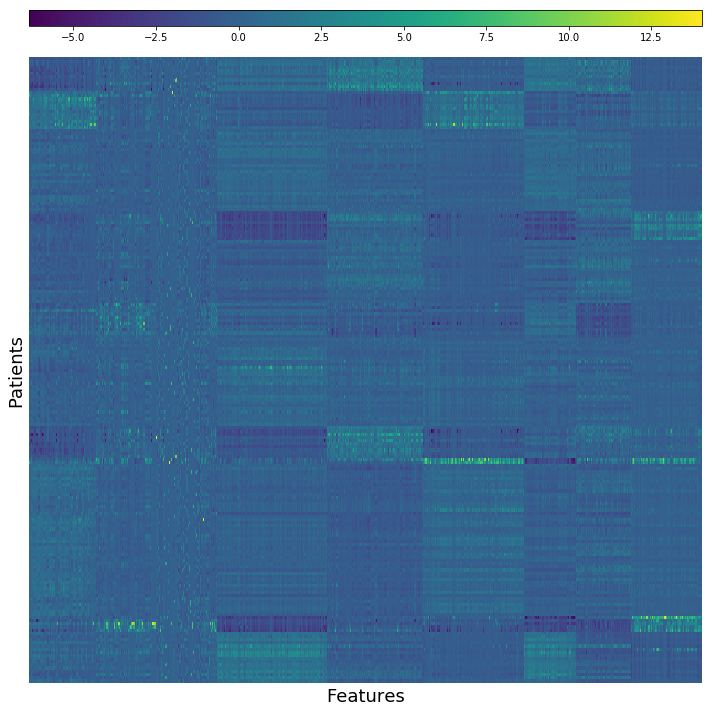

In [22]:
fig, (cbar_ax, map_ax) = plt.subplots(
    nrows=2, figsize=(10, 10),  
    gridspec_kw={'height_ratios':[0.025, 1]}
)
sns.heatmap(
    bic_fit_data, 
    ax=map_ax, 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(bic_fit_data), 
    vmax=np.max(bic_fit_data),
    cbar=False
)
#coords = checker_coords(bic_model, best_config['n_clusters'])
#for num in coords.index:
#    plt.plot(
#        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
#        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
#        linewidth=2, c='orangered' #darkred
#)
fig.colorbar(
    map_ax.get_children()[0], 
    cax=cbar_ax, 
    orientation='horizontal'
)
map_ax.set_xlabel('Features', fontsize=18)
map_ax.set_ylabel('Patients', fontsize=18)
map_ax.axes.get_xaxis().set_ticks([])
map_ax.axes.get_yaxis().set_ticks([])

plt.tight_layout()


plt.savefig(
    './../../../figures/cluster_analysis/bicmap.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

# Spectral Coclustering

In [23]:
np.random.seed(0)   
co_grid = ParameterGrid(
    {
        'n_clusters': [
            np.random.choice(np.arange(30), size=1)[0] for _ in range(25)
        ],
    }
)
# Id config with best score results and plot with grid.
co_scores = {}
for num, co_param_config in enumerate(co_grid):
    try:
        co_model = SpectralCoclustering(
            random_state=SEED, svd_method='arpack'
        )
        co_clusters = biclusters(
            co_model, X_std, co_param_config
        )
        co_scores[num] = co_clusters.external_metrics
    except:
        pass

/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/anaconda/lib/python3.6/site-packages/sklearn/cluster/bicluster.py:298: RuntimeWarning: divide by zero encountered in log2
  n_sv = 1 + int(np.ceil(np.log2(self.n_clusters)))
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - np.mean(avg_cols)) / np.std(avg_cols)
/Users/severinlangberg/Desktop/ms/biorad/data/exploration/concensus_clustering.py:72: RuntimeWarning: invalid value encountered in true_divide
  avg_cols_std = (avg_cols - n

In [24]:
# Determine best coclustering config.
avg_co_scores = []
for scores in co_scores.values():
    _, non_inf_idx = np.where(scores.values != float('inf'))
    score = sum(scores.values.ravel()[non_inf_idx]) / len(non_inf_idx)
    avg_co_scores.append(score)
    
best_config = co_grid[np.argmin(avg_co_scores)]
best_config, min(avg_bic_scores)

({'n_clusters': 12}, 0.6052992748819872)

In [25]:
co_model = SpectralCoclustering(
    random_state=SEED, svd_method='arpack'
)
co_model.set_params(**best_config)
co_model.fit(X_std)
co_row_sorted = X_std[np.argsort(co_model.row_labels_), :]
co_fit_data = co_row_sorted[:, np.argsort(co_model.column_labels_)]

In [26]:
# The number of features from each feature category per column bicluster.

pet_category_stats = {}
ct_category_stats = {}

for co_col_idx in np.unique(co_model.column_labels_):    
    # ID samples belonging to current cluster.
    col_cluster_samples = np.squeeze(np.where(co_model.column_labels_ == co_col_idx))
    # Store fractions of present feature categories per modality.
    pet_output, ct_output = to_feature_categories(col_cluster_samples)
    pet_category_stats[co_col_idx] = pet_output
    ct_category_stats[co_col_idx] = ct_output
    
pet_df = pd.DataFrame(pet_category_stats).T
ct_df = pd.DataFrame(ct_category_stats).T

In [27]:
# * Hue row (patient) clusters according to outcome. Capable of producing clusters with
#   pure outcomes? If so, which features separates a pure PFS outcome cluster from a 
#   cluster with no PFS outcomes?

# The proportion of outcomes per cocluster.
co_pfs_stats, co_not_pfs_stats, cluster_ids = [], [], []
for cluster_idx in np.unique(co_model.row_labels_):
    cluster_ids.append(cluster_idx)
    targets = np.where(co_model.row_labels_ == cluster_idx)
    co_pfs_stats.append(sum(y[targets] == 0) / np.size(y))
    co_not_pfs_stats.append(sum(y[targets] == 1) / np.size(y))
sum(co_pfs_stats), sum(co_not_pfs_stats), len(cluster_ids)

(0.6767676767676766, 0.3232323232323232, 12)

In [28]:
len(co_pfs_stats), len(co_not_pfs_stats)

(12, 12)

In [29]:
sorted_cluster_idx = np.concatenate((cluster_ids, cluster_ids))
comb_results = np.concatenate((co_pfs_stats, co_not_pfs_stats))

results_id =  np.concatenate((
    ['Progression-free Survival'] * len(co_pfs_stats), 
    ['Other Event'] * len(co_not_pfs_stats)
))
df_co_stats = pd.DataFrame(
    {
        'comb_results': comb_results,
        'results_id': results_id
    },
    index=sorted_cluster_idx,
)
df_co_stats.head()

,comb_results,results_id
0,0.095960,Progression-free Survival
1,0.020202,Progression-free Survival
2,0.045455,Progression-free Survival
3,0.161616,Progression-free Survival
4,0.040404,Progression-free Survival


In [30]:
(a, b) = df_co_stats.groupby('results_id')
a[0], a[1]['comb_results'].sum(), b[0], b[1]['comb_results'].sum()

('Other Event',
 0.3232323232323232,
 'Progression-free Survival',
 0.6767676767676766)

In [31]:
frames = {}
# NB: Not all features can be divided into PET/CT categories.
for pet_col, ct_col in zip(pet_df, ct_df):
    
    
    assert pet_col == ct_col
    if 'clinical' in pet_col:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col]],

        )
        frame = frame.T
        frame.columns=['clinical']
        
    elif 'shape' in pet_col:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col]],

        )
        frame = frame.T
        frame.columns=['shape']
    else:
        frame = pd.DataFrame(
            [ct_df.loc[:, ct_col], pet_df.loc[:, pet_col]],

        )
        frame = frame.T
        frame.columns = ['CT', 'PET']
    
    frame.index = np.arange(frame.index.size) + 1
    frames[ct_col] = frame

frames.keys()

dict_keys(['PETparam', 'clinical', 'firstorder', 'glcm', 'gldm', 'glrlm', 'glszm', 'ngtdm', 'shape'])

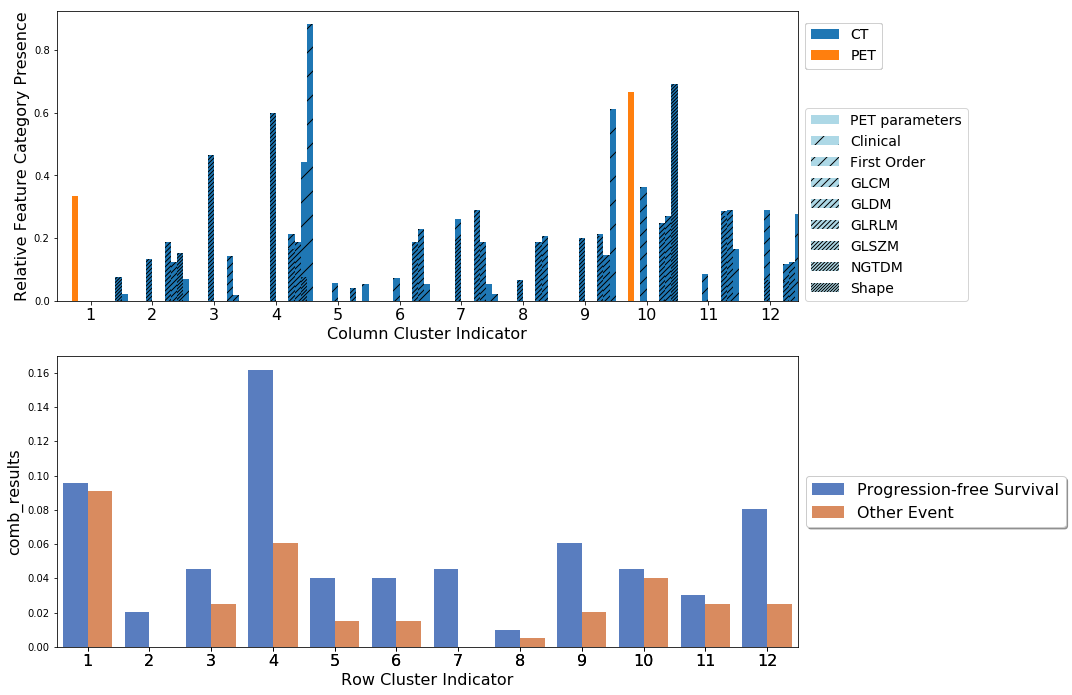

In [32]:
# * Possible to separate patients based on clinical outcomes whilst
#   identifying separating features?
# * Hue row (patient) clusters according to outcome. Capable of producing clusters with
#   pure outcomes? If so, which features separates a pure PFS outcome cluster from a 
#   cluster with no PFS outcomes?


H = '/'
labels = [
    'PET parameters', 'Clinical', 'First Order', 
    'GLCM', 'GLDM', 'GLRLM', 'GLSZM', 'NGTDM', 
    'Shape'
]

n_df = len(frames.keys())
n_col = len(list(frames.values())[0].columns) 
n_ind = len(list(frames.values())[0].index)

fig, (axis1, axis2) = plt.subplots(nrows=2, ncols=1, figsize=(15, 10))
axis1.set_ylabel('Relative Feature Category Presence', fontsize=16)
axis1.set_xlabel('Column Cluster Indicator', fontsize=16)
for df in frames.values():
    df.plot(
        kind='bar',
        linewidth=0,
        stacked=True,
        ax=axis1,
        legend=False,
        grid=False
    )
    h, l = axis1.get_legend_handles_labels() 
    for i in range(0, n_df * n_col, n_col): 
        for j, pa in enumerate(h[i:i+n_col]):
            for rect in pa.patches: 
                rect.set_x(rect.get_x() + 1 / float(n_df + 1) * i / float(n_col))
                rect.set_hatch(H * int(i / n_col)) 
                rect.set_width(1 / float(n_df + 1))

    axis1.set_xticks((np.arange(0, 2 * n_ind, 2) + 1 / float(n_df + 1)) / 2.)
    axis1.set_xticklabels(df.index, rotation=0, fontsize=16)
    
    n = []        
    for i in range(n_df):
        n.append(axis1.bar(0, 0, color='lightblue', hatch=H * i))
    
    l1 = axis1.legend(h[:n_col], l[:n_col], loc=[1.01, 0.8], fontsize=14)
    l2 = axis1.legend(n, labels, loc=[1.01, 0], fontsize=14) 
    axis1.add_artist(l1)
    

axis2.set_xlabel('Row Cluster Indicator', fontsize=16)
axis2.set_ylabel('Relative Outcome Category Presence', fontsize=16)
sns.barplot(
    x=sorted_cluster_idx,
    y='comb_results',
    hue='results_id',
    data=df_co_stats,
    palette='muted',
    ax=axis2
)

axis2.legend(
    fontsize=16,
    loc='center left', 
    bbox_to_anchor=(1, 0.5),
    ncol=1, 
    fancybox=True, 
    shadow=True
)

axis2.set_xticks(sorted_cluster_idx)
axis2.set_xticklabels(sorted_cluster_idx + 1, rotation=0, fontsize=16)

plt.tight_layout()


plt.savefig(
    './../../../figures/cluster_analysis/row_column_coclusters.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

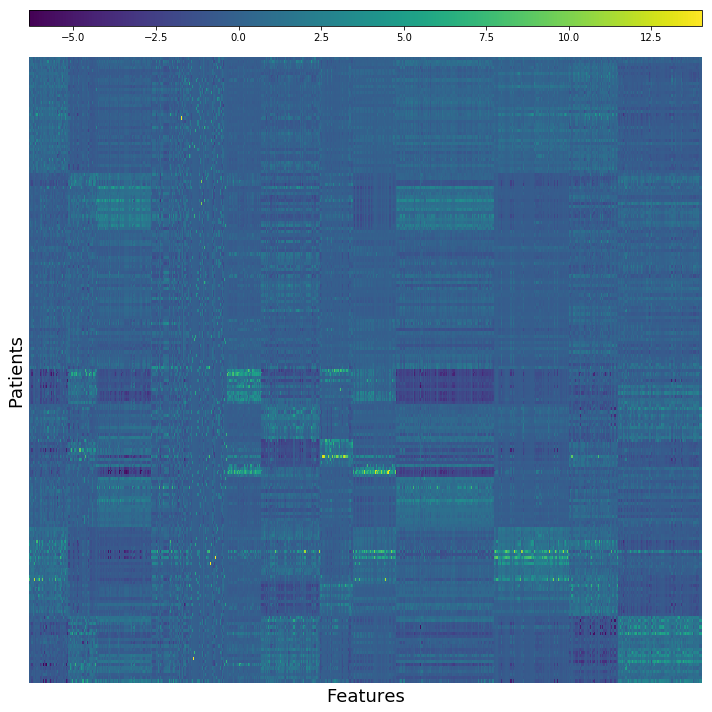

In [33]:
fig, (cbar_ax, map_ax) = plt.subplots(
    nrows=2, figsize=(10, 10),  
    gridspec_kw={'height_ratios':[0.025, 1]}
)
sns.heatmap(
    co_fit_data, 
    ax=map_ax, 
    robust=True, 
    cmap=plt.cm.viridis,#plt.cm.RdBu_r, 
    fmt='f', 
    vmin=np.min(co_fit_data), 
    vmax=np.max(co_fit_data),
    cbar=False
)
#coords = checker_coords(bic_model, best_config['n_clusters'])
#for num in coords.index:
#    plt.plot(
#        (coords.loc[num, ['x1', 'x2', 'x2', 'x1', 'x1']]),
#        (coords.loc[num, ['y1', 'y1', 'y2', 'y2', 'y1']]),
#        linewidth=2, c='orangered' #darkred
#)
fig.colorbar(
    map_ax.get_children()[0], 
    cax=cbar_ax, 
    orientation='horizontal'
)
map_ax.set_xlabel('Features', fontsize=18)
map_ax.set_ylabel('Patients', fontsize=18)
map_ax.axes.get_xaxis().set_ticks([])
map_ax.axes.get_yaxis().set_ticks([])

plt.tight_layout()


plt.savefig(
    './../../../figures/cluster_analysis/comap.png',
    bbox_inches='tight',
    transparent=True,
    dpi=600, 
)

## DGUFS & Group LASSO

In [39]:
from dgufs import DGUFS
#!pip install pyglmnet

from pyglmnet import GLM

In [35]:
np.random.seed(0)
dgufs_param_grid = ParameterGrid(
    {
        'num_clusters': [
            np.random.choice(np.arange(30), size=1)[0] for _ in range(25)
        ],
        'num_features': [
            np.random.choice(np.arange(500), size=1)[0] for _ in range(25)
        ],
        
    }
)

In [36]:
for dgufs_param_config in dgufs_param_grid:
    model = DGUFS(**dgufs_param_config)
    model.fit(X_std)
    gl_glm = GLM(
        distr='binomial', 
        tol=1e-2,
        group=group_idxs, 
        score_metric="pseudo_R2",
        alpha=1.0
    )

KeyboardInterrupt: 

In [43]:
dgufs_param_config

{'num_clusters': 12, 'num_features': 464}

In [44]:
model.support

array([  0,   1,   2,   3,   6,   8,   9,  10,  14,  15,  17,  18,  20,
        21,  22,  23,  24,  25,  26,  28,  32,  34,  35,  36,  38,  44,
        46,  48,  50,  51,  53,  56,  58,  64,  66,  67,  68,  71,  72,
        73,  75,  79,  80,  81,  83,  85,  87,  88,  89,  90,  91,  92,
        94,  95,  96,  97, 100, 103, 104, 105, 106, 107, 108, 112, 113,
       115, 117, 118, 119, 121, 122, 125, 126, 127, 128, 129, 130, 131,
       133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145,
       146, 148, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 163,
       164, 166, 168, 169, 171, 172, 173, 175, 176, 178, 179, 180, 182,
       184, 186, 187, 188, 189, 190, 192, 194, 196, 197, 198, 199, 200,
       201, 202, 203, 204, 205, 207, 209, 210, 211, 212, 213, 214, 215,
       216, 219, 220, 221, 222, 223, 224, 225, 227, 228, 230, 231, 232,
       233, 234, 235, 236, 237, 238, 240, 242, 244, 245, 246, 247, 248,
       249, 250, 251, 252, 253, 255, 256, 257, 260, 261, 262, 26